In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt


In [0]:
from google.colab import files
files.upload()

MessageError: ignored

In [0]:
data = pd.read_csv('train.csv',index_col='Id')

##i.) Identify and handle the missing data.
###The follwing are column names and instance counts of N/A values in the dataset. These are the ones we have to find a way to impute.

In [254]:
nancount = data.isna().sum()
nancount = nancount[nancount > 0]
print("The following are the column names and instance counts of N/A values in the dataset\n")
print(nancount)

The following are the column names and instance counts of N/A values in the dataset

LotFrontage      259
Alley           1369
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


###Now, we want to get a sense for which attributes we should take the **mean** (Continuous) and which values we should take another approach (Categorical). (In our case, we will choose to make "N/A" its own category. 
We choose to do this because of the nature of the categories themselves: It seems more likely that "N/A" means that the instance doesn't fit in any category for one reason or another, and that "unfitness" might prove to be more valuable information than slapping on the most common category label for the sake of having something there.

In [255]:
means = data.mean(axis=0)[nancount.keys()]
print(means)


LotFrontage       70.049958
Alley                   NaN
MasVnrType              NaN
MasVnrArea       103.685262
BsmtQual                NaN
BsmtCond                NaN
BsmtExposure            NaN
BsmtFinType1            NaN
BsmtFinType2            NaN
Electrical              NaN
FireplaceQu             NaN
GarageType              NaN
GarageYrBlt     1978.506164
GarageFinish            NaN
GarageQual              NaN
GarageCond              NaN
PoolQC                  NaN
Fence                   NaN
MiscFeature             NaN
dtype: float64


###This makes it easy: it looks like Lot Frontage, MasVnrArea, and Garage Built are the only averageable columns, so we will impute N/A values with their mean, and the rest we will let N/A values be their own category.
This is because most of the houses have N/A values because they don't match the given criterion, not because they are "missing" any data.

In [0]:
for col in means.keys():
  if means[col] != None:
    data[col].fillna(means[col],inplace=True)


##ii.) Identify variables with nonnumeric values that are misencoded as numbers.

### Delete if no value added to model,
### Recode into strings if helpful for human-readability
### One-Hot Encode if useful in a regression model


**Classes**

####1MSSubClass: One-Hot Encoding.
This class is given a numeric value, but there is not necessarily a linear scale between classes. It is also too good of information to throw out.

####OverallQual / OverallCond: Keep as-is
These classes are both given as numeric values ranked on a scale of 1-10, but because the classes do share an ordinal relationship, we will keep those classes as-is.


In [257]:
data

MSSubClass MSZoning  LotFrontage  ...  SaleType SaleCondition SalePrice
Id                                      ...                                  
1             60       RL         65.0  ...        WD        Normal    208500
2             20       RL         80.0  ...        WD        Normal    181500
3             60       RL         68.0  ...        WD        Normal    223500
4             70       RL         60.0  ...        WD       Abnorml    140000
5             60       RL         84.0  ...        WD        Normal    250000
...          ...      ...          ...  ...       ...           ...       ...
1456          60       RL         62.0  ...        WD        Normal    175000
1457          20       RL         85.0  ...        WD        Normal    210000
1458          70       RL         66.0  ...        WD        Normal    266500
1459          20       RL         68.0  ...        WD        Normal    142125
1460          20       RL         75.0  ...        WD        Normal    147500

[1460 rows x 80 columns]

In [0]:
def onehot(col_name):
  k = pd.get_dummies(data[col_name],drop_first=True)
  return pd.concat([data,k],axis=1).drop([col_name],axis=1)

In [0]:
# One-Hot Encode MSSubClass
data = onehot("MSSubClass")

In [260]:
data

MSZoning  LotFrontage  LotArea Street Alley  ... 90 120 160 180 190
Id                                                ...                   
1          RL         65.0     8450   Pave   NaN  ...  0   0   0   0   0
2          RL         80.0     9600   Pave   NaN  ...  0   0   0   0   0
3          RL         68.0    11250   Pave   NaN  ...  0   0   0   0   0
4          RL         60.0     9550   Pave   NaN  ...  0   0   0   0   0
5          RL         84.0    14260   Pave   NaN  ...  0   0   0   0   0
...       ...          ...      ...    ...   ...  ... ..  ..  ..  ..  ..
1456       RL         62.0     7917   Pave   NaN  ...  0   0   0   0   0
1457       RL         85.0    13175   Pave   NaN  ...  0   0   0   0   0
1458       RL         66.0     9042   Pave   NaN  ...  0   0   0   0   0
1459       RL         68.0     9717   Pave   NaN  ...  0   0   0   0   0
1460       RL         75.0     9937   Pave   NaN  ...  0   0   0   0   0

[1460 rows x 93 columns]

##iii.) 
####Identify and One-Hot Encode any non-numerical categorical variables that need to be included in the regression model and delete those which do not need to be included.

**Important Categorical Columns**
1MSSubClass: We already one-hot-encoded this one. This tells us the layout of the house, which seems like it would be very important for predicting sale price.

Neighborhood: This would be a very important thing to know, as neighborhood quality has a large effect on sale price.

HouseStyle: This feels like a good measure since it encompasses the major differences between generic house types.



In [0]:
# One-Hot Encode "Neighborhood" and "HouseStyle"
data = onehot("Neighborhood")
data = onehot("HouseStyle")


In [262]:
data

MSZoning  LotFrontage  LotArea Street  ... 2.5Unf 2Story SFoyer SLvl
Id                                          ...                          
1          RL         65.0     8450   Pave  ...      0      1      0    0
2          RL         80.0     9600   Pave  ...      0      0      0    0
3          RL         68.0    11250   Pave  ...      0      1      0    0
4          RL         60.0     9550   Pave  ...      0      1      0    0
5          RL         84.0    14260   Pave  ...      0      1      0    0
...       ...          ...      ...    ...  ...    ...    ...    ...  ...
1456       RL         62.0     7917   Pave  ...      0      1      0    0
1457       RL         85.0    13175   Pave  ...      0      0      0    0
1458       RL         66.0     9042   Pave  ...      0      1      0    0
1459       RL         68.0     9717   Pave  ...      0      0      0    0
1460       RL         75.0     9937   Pave  ...      0      0      0    0

[1460 rows x 122 columns]

In [263]:
# Now, remove all the rest of the non-numerical columns--we don't need them anymore
data = data.select_dtypes(['number'])
data

LotFrontage  LotArea  OverallQual  ...  2Story  SFoyer  SLvl
Id                                       ...                      
1            65.0     8450            7  ...       1       0     0
2            80.0     9600            6  ...       0       0     0
3            68.0    11250            7  ...       1       0     0
4            60.0     9550            7  ...       1       0     0
5            84.0    14260            8  ...       1       0     0
...           ...      ...          ...  ...     ...     ...   ...
1456         62.0     7917            6  ...       1       0     0
1457         85.0    13175            6  ...       0       0     0
1458         66.0     9042            7  ...       1       0     0
1459         68.0     9717            5  ...       0       0     0
1460         75.0     9937            5  ...       0       0     0

[1460 rows x 81 columns]

###iv.) For each continuous variable, plot SalePrices as a function of that variable.
If the relationship looks nonlinear, Engineer an appropriate nonlinear feature to add to the dataframe.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:338: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


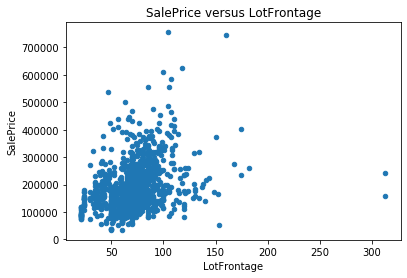

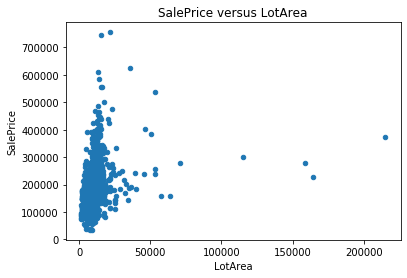

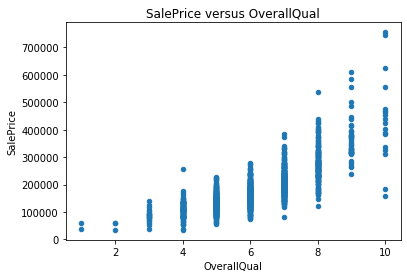

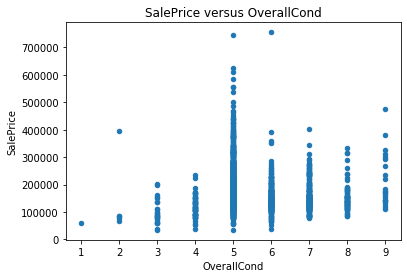

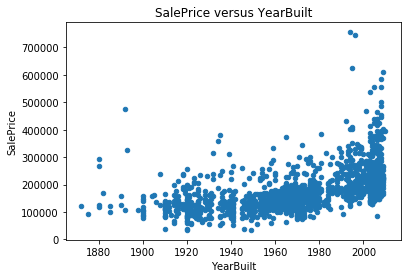

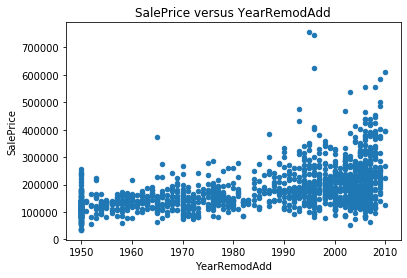

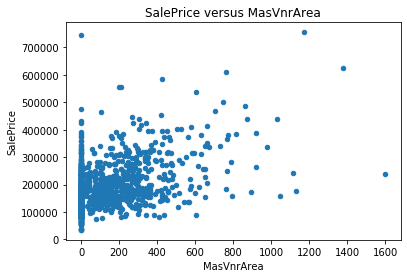

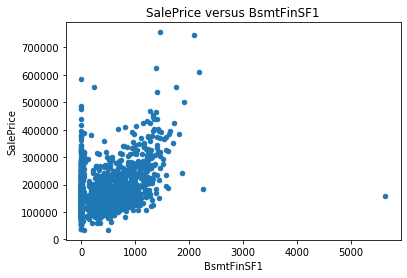

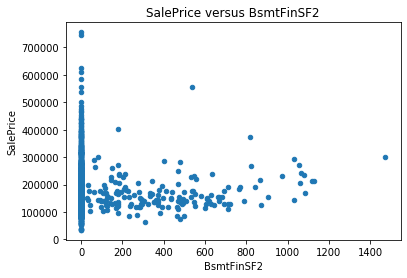

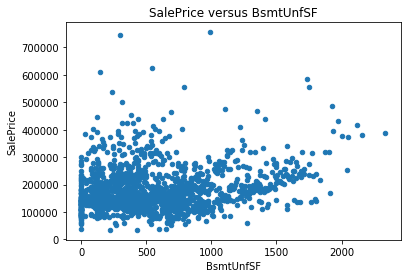

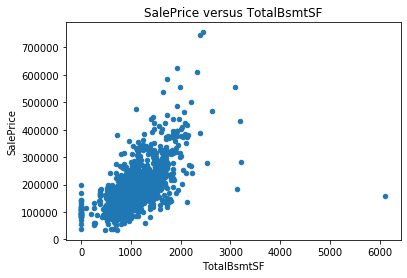

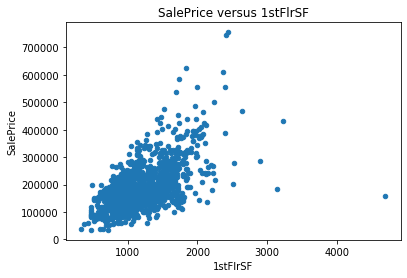

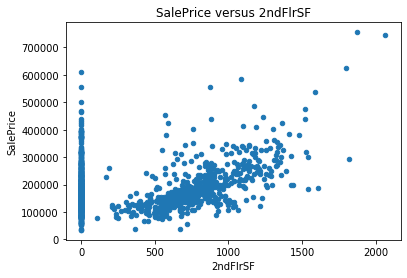

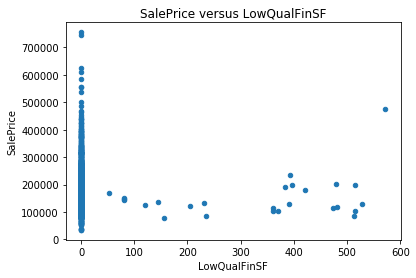

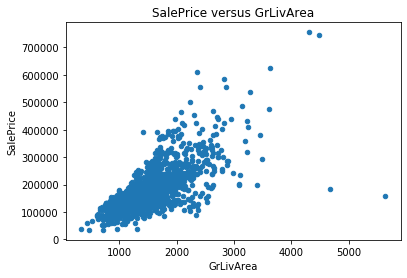

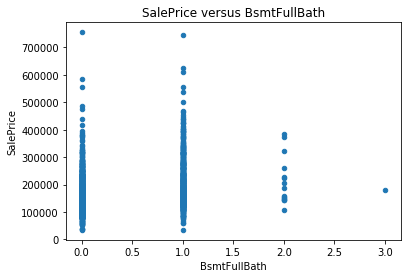

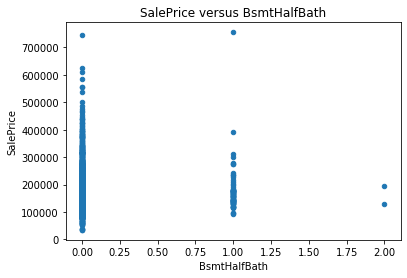

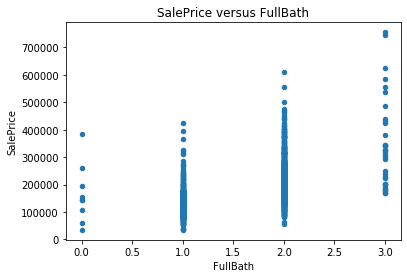

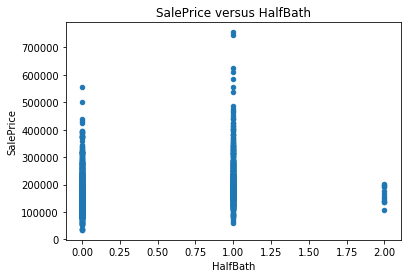

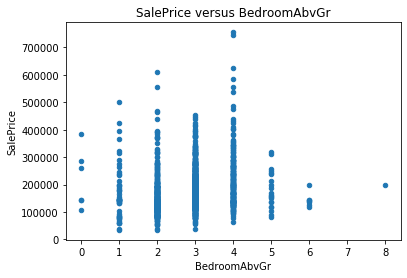

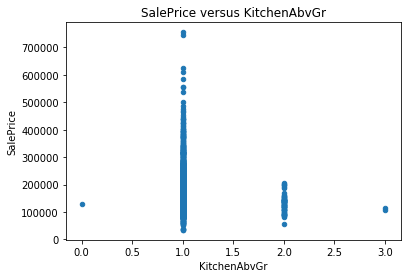

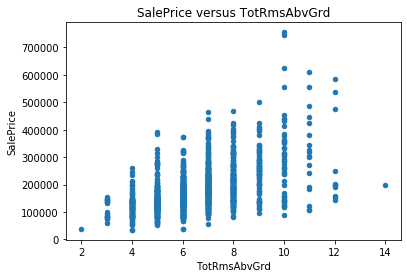

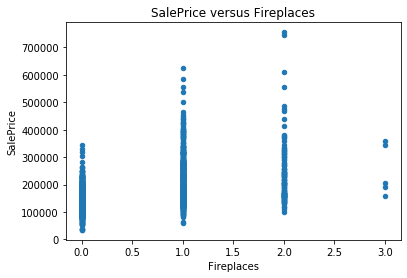

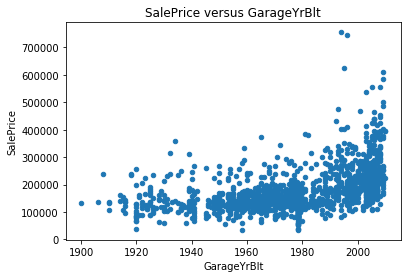

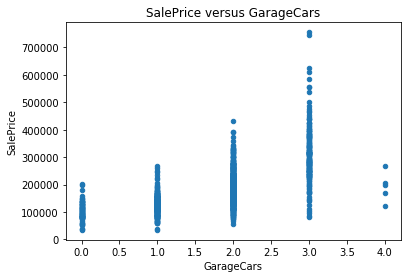

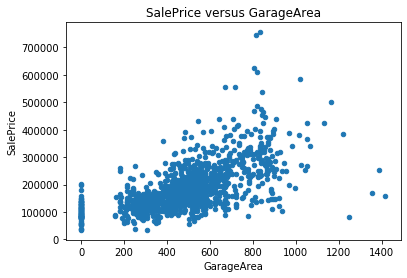

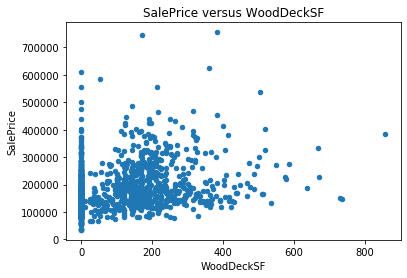

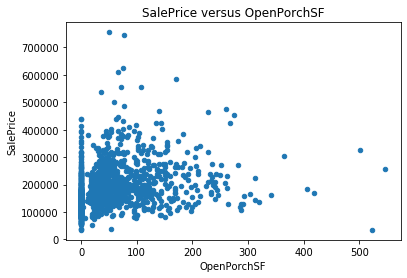

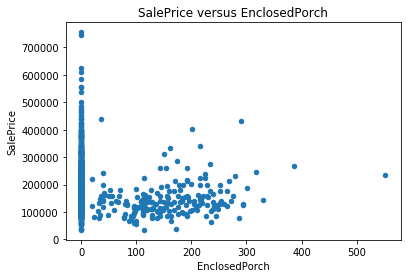

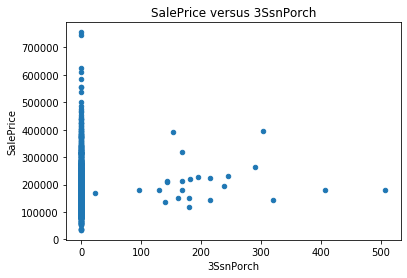

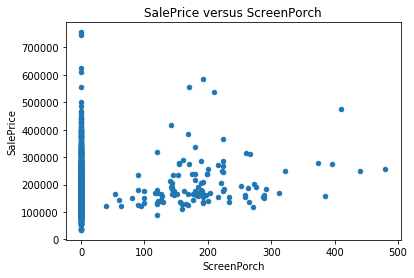

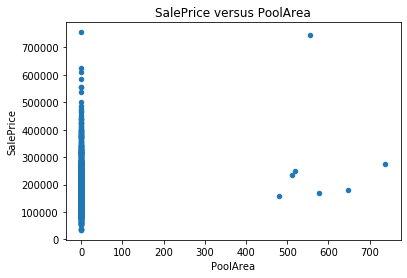

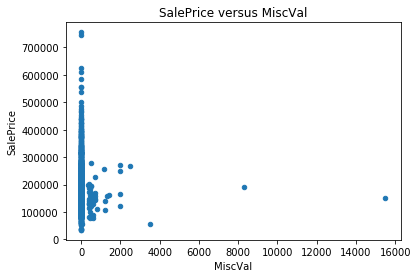

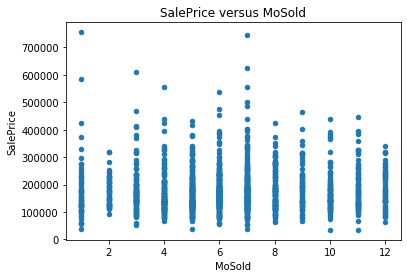

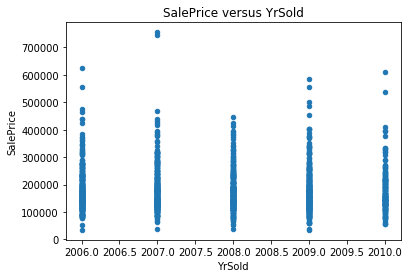

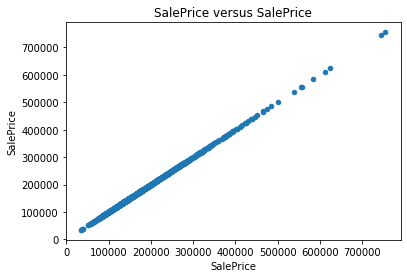

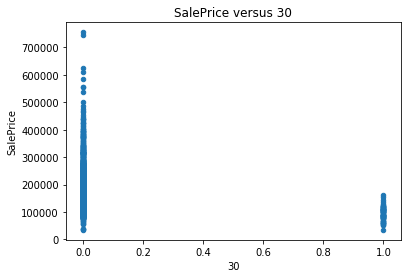

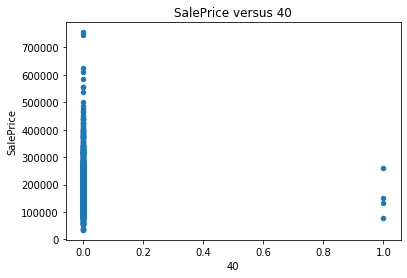

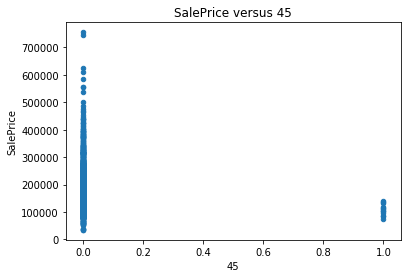

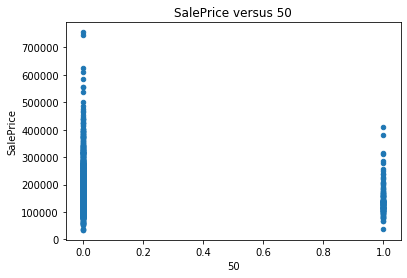

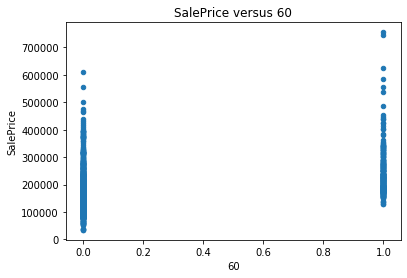

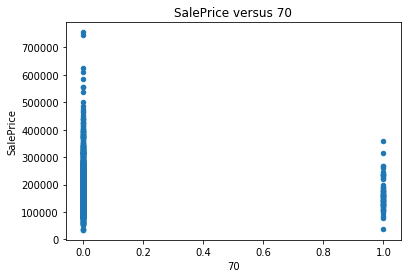

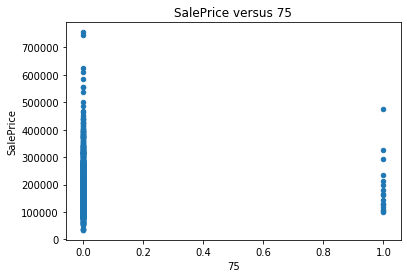

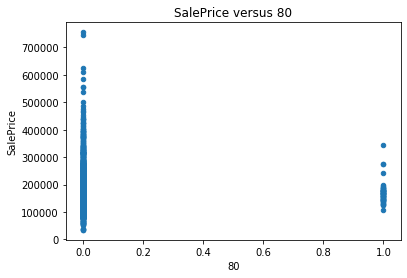

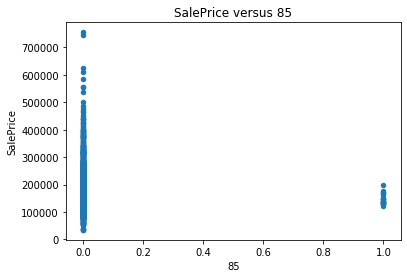

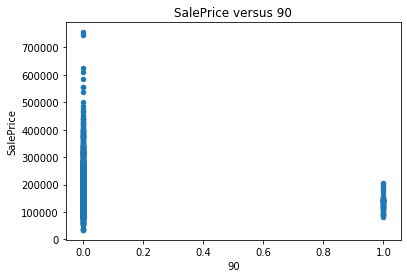

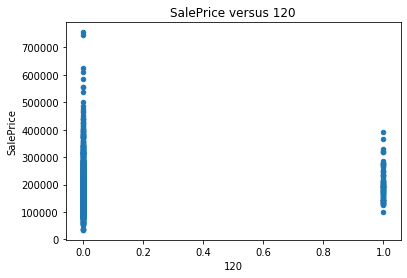

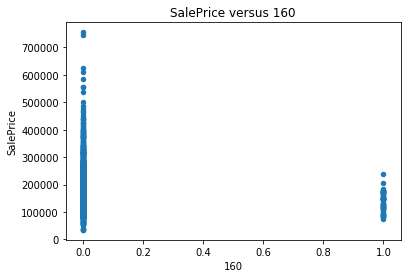

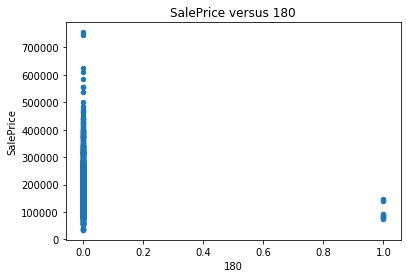

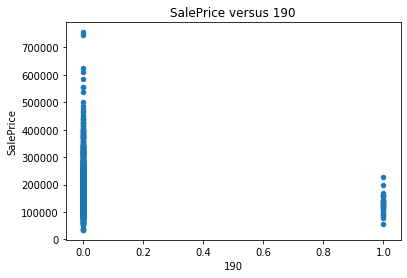

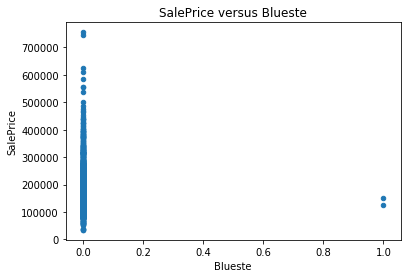

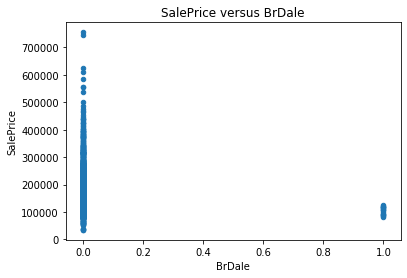

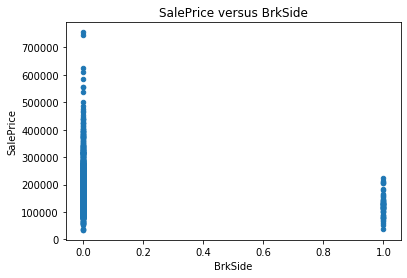

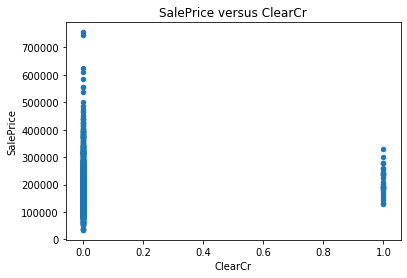

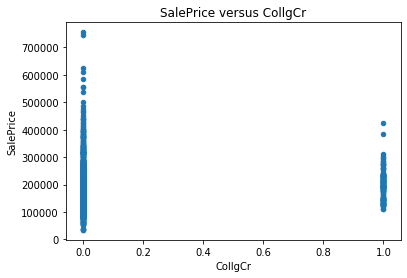

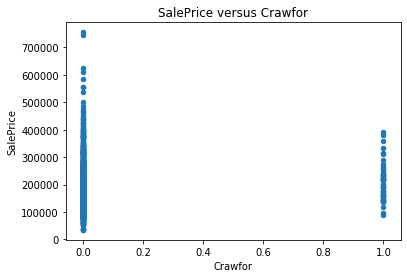

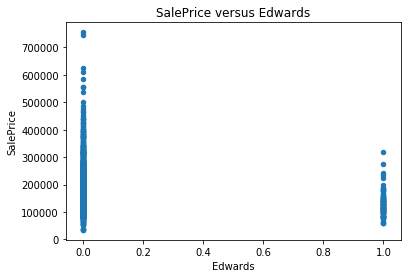

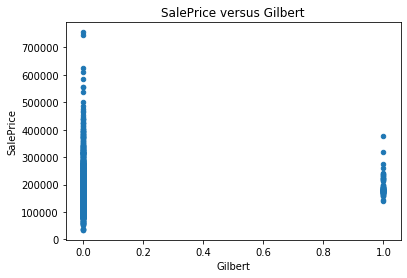

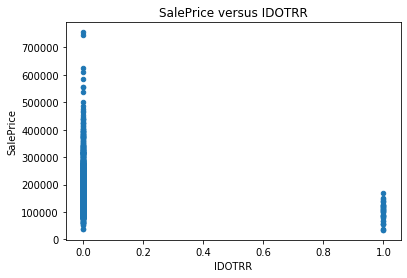

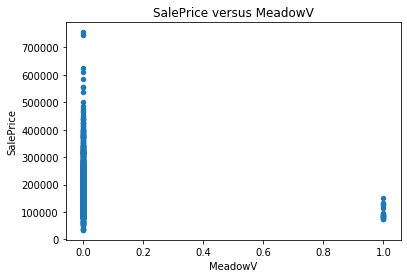

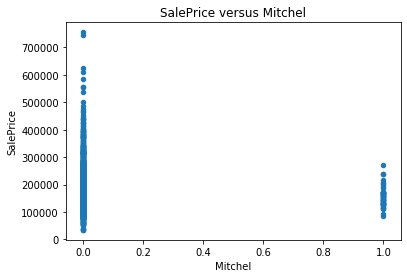

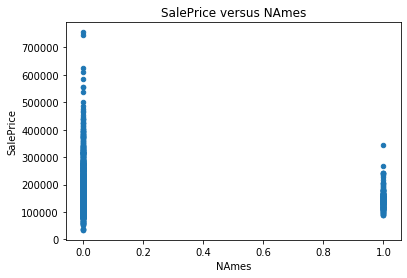

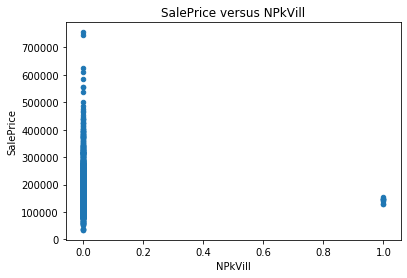

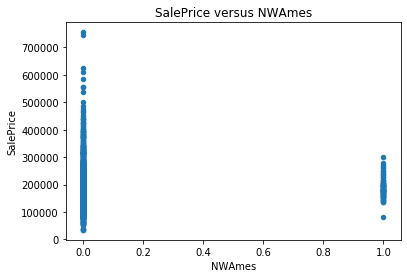

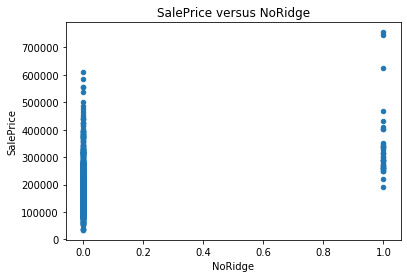

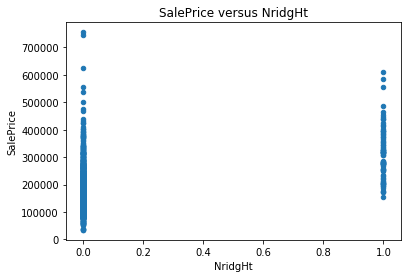

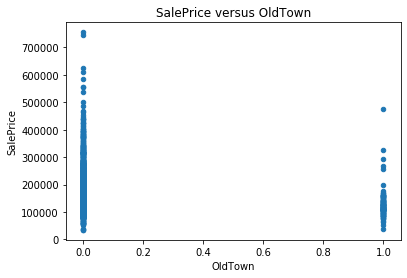

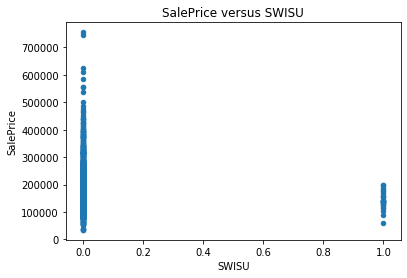

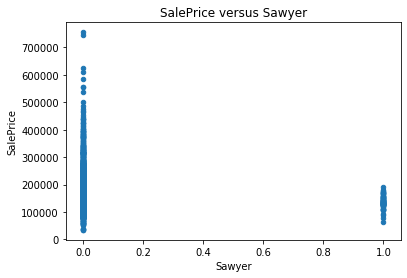

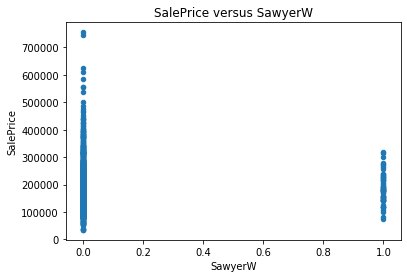

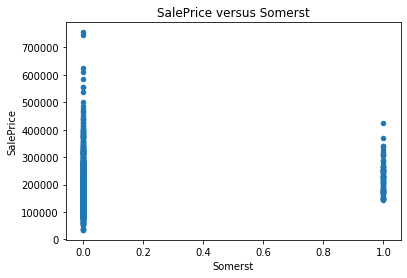

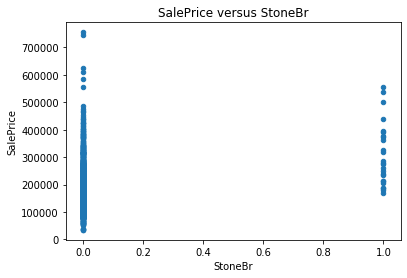

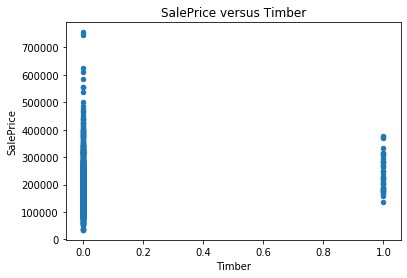

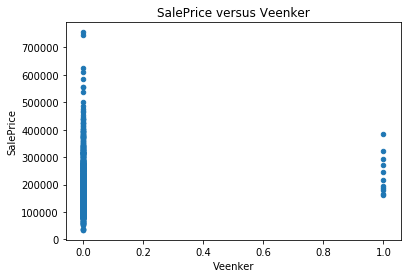

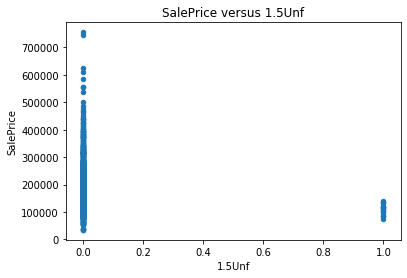

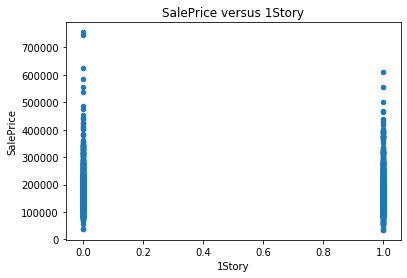

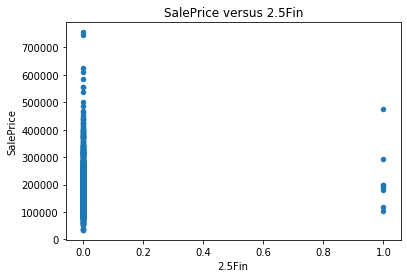

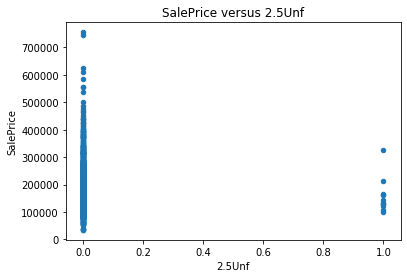

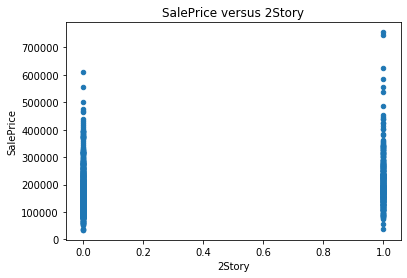

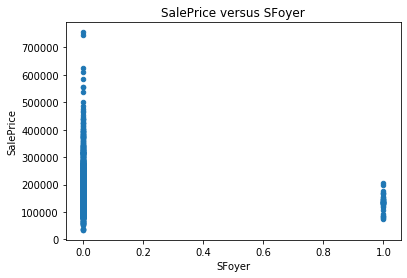

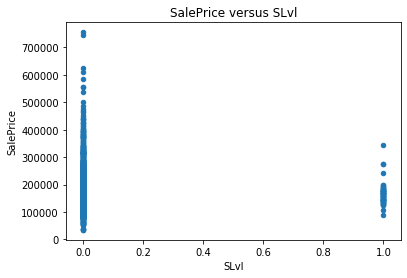

In [264]:
for k in data.columns:
  data.plot(kind="scatter",x=k,y="SalePrice")
  plt.title("SalePrice versus {}".format(k))
  plt.plot()

From looking at the graphs, I think the two most likely candidates for non-linear relationships are "YearBuilt" and "GarageYearBuilt". I'll add a column with the square of those same values.

In [265]:
data["YearBuiltSq"] = data["YearBuilt"]**2
data["GarageYrBltSq"] = data["GarageYrBlt"]**2
data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


LotFrontage  LotArea  OverallQual  ...  SLvl  YearBuiltSq  GarageYrBltSq
Id                                       ...                                  
1            65.0     8450            7  ...     0      4012009      4012009.0
2            80.0     9600            6  ...     0      3904576      3904576.0
3            68.0    11250            7  ...     0      4004001      4004001.0
4            60.0     9550            7  ...     0      3667225      3992004.0
5            84.0    14260            8  ...     0      4000000      4000000.0
...           ...      ...          ...  ...   ...          ...            ...
1456         62.0     7917            6  ...     0      3996001      3996001.0
1457         85.0    13175            6  ...     0      3912484      3912484.0
1458         66.0     9042            7  ...     0      3767481      3767481.0
1459         68.0     9717            5  ...     0      3802500      3802500.0
1460         75.0     9937            5  ...     0      3861225      3861225.0

[1460 rows x 83 columns]

###v.) Identify three combinations of features f1*f2 which seem likely to be useful for a regression model.

I am adding OverallCond * OverallQual as a weighted Overall score,

LotArea / LotFrontage as a measure of approximate LotDepth, and 

BsmtUnfSF / TotalBsmtSF which measures the percentage of the basement which remains unfinished. 

In [299]:
data["OverallWeightedScore"] = data["OverallCond"] * data["OverallQual"]

data["LotDepth"] = data["LotArea"] / data["LotFrontage"]

data["BsmtPercFinished"] = 1 - data["BsmtUnfSF"] / data["TotalBsmtSF"]
data.fillna(value={"BsmtPercFinished":0}, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

###vi.) Add a constant column to the dataframe


In [269]:
data["Constant"] = 1
data

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


LotFrontage  LotArea  OverallQual  ...    LotDepth  BsmtPercFinished  Constant
Id                                       ...                                        
1            65.0     8450            7  ...  130.000000          0.824766         1
2            80.0     9600            6  ...  120.000000          0.774960         1
3            68.0    11250            7  ...  165.441176          0.528261         1
4            60.0     9550            7  ...  159.166667          0.285714         1
5            84.0    14260            8  ...  169.761905          0.572052         1
...           ...      ...          ...  ...         ...               ...       ...
1456         62.0     7917            6  ...  127.693548          0.000000         1
1457         85.0    13175            6  ...  155.000000          0.618029         1
1458         66.0     9042            7  ...  137.000000          0.238715         1
1459         68.0     9717            5  ...  142.897059          1.000000         1
1460         75.0     9937            5  ...  132.493333          0.891720         1

[1460 rows x 87 columns]

###vii.) Run an OLS regression on your model

In [321]:
cols = data.columns.to_list()
cols.remove("SalePrice")

ols  = np.linalg.lstsq(data[cols].values, data["SalePrice"].values)
beta = ols[0]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  after removing the cwd from sys.path.


###viii.) Interpret the three largest positive and negative coefficients in beta

In [333]:
sorted_weights = np.argsort(beta)
print("Lowest weights:", [cols[x] for x in sorted_weights[:3]])
print("Highest weights:", [cols[x] for x in sorted_weights[-3:]])


Lowest weights: [160, 120, 'NWAmes']
Highest weights: ['NridgHt', 'StoneBr', 'Constant']


We can interpret the above results as the following:

The three factors we found that most negatively affect the Sale Price are 


1.) Being a "2-story PUD (Planned Unit Development)


2.) Being a "1-story PUD"


3.) Being located in the neighborhood of "NWAmes"

The three factors that most positively affected Sale Price are


1.) Being located in the neighborhood of "NridgHt"


2.) Being located in the neighborhood of "StoneBr"


3.) Our Constant weight (This obviously doesn't change from house to house. A large constant weight means that the average SalePrice is greater than $0, which we would cerainly hope for.)